# Predicting the Football (Soccer) World Cup Winner with Machine Learning

# Data I/O
Four datasets were used:

1. FIFA rankings from 1992 to 2022

2. International Soccer matches from 1872 to 2022 

3. FIFA World Cup 2022 data set

4. Elo rating at the beginning of the year of each country from 1992 to 2022

## Data preprocessing

### Rankings

In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

# Get the ranking Data
rankings = pd.read_csv("https://raw.githubusercontent.com/iamtlcs/STAT3011-Group5-Project2/main/fifa_ranking-2022-12-22.csv")

# Fix some country names
rankings = rankings.replace({"IR Iran": "Iran",'Netherlands': 'Netherland'})

#get the years column
import datetime
from datetime import datetime

dt = rankings["rank_date"]

# dt = datetime.strptime(dt, '%Y-%m-%d')
dt = dt.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

# train["pickup_month"] = dt.month
rankings["year"] = dt.map(lambda x: x.year)

rankings.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,year
0,74,Madagascar,MAD,18.0,0.0,0,CAF,1992-12-31,1992
1,52,Qatar,QAT,27.0,0.0,0,AFC,1992-12-31,1992
2,51,Senegal,SEN,27.0,0.0,0,CAF,1992-12-31,1992
3,50,El Salvador,SLV,28.0,0.0,0,CONCACAF,1992-12-31,1992
4,49,Korea Republic,KOR,28.0,0.0,0,AFC,1992-12-31,1992


In [46]:
#we want the ranks before the world cup 2022 starts
#while the ranks after 2022-12-22 will also be deleted by later codes.
rankings=rankings[~rankings['rank_date'].isin(["2022-12-22"])] 

### Elo rating

In [47]:
# Get the elo rating Data
elorating = pd.read_csv("https://raw.githubusercontent.com/iamtlcs/STAT3011-Group5-Project2/main/elo_rating-1992-2022.csv")

elorating = elorating.replace({"China": "China PR", 
                                 "Congo": "Congo PR", 
                                 "North Korea": "Korea DPR", 
                                 "United States": "USA", 
                                 "South Korea" : "Korea Republic", 
                                 "Turks and Caicos" : "Turks and Caicos Islands",
                                 "Netherlands" : "Netherland"})

elorating.head()

,country,elo,year
0,Germany,2087,1992
1,France,2009,1992
2,England,1987,1992
3,Argentina,1983,1992
4,Italy,1971,1992


### Matches

In [48]:
# Get the match Data
matches = pd.read_csv("https://raw.githubusercontent.com/iamtlcs/STAT3011-Group5-Project2/main/till-2022-results.csv")
# Fix some country names
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})

#get the years column
dt1 = matches["date"]

# dt1 = datetime.strptime(dt, '%Y-%m-%d')
dt1 = dt1.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

# train["pickup_month"] = dt.month
matches["year"] = dt1.map(lambda x: x.year)

matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876


In [49]:
#get the recent 60 years data
matches=matches[(matches['year']<2023)&(matches['year']>1982)]

### Preprocessing of elo ratings with rankings and matches.

In [50]:
# rankings

# we want to have the ranks for every day 
# We use resample to sample by Day and get the first date
rankings = rankings.set_index(['rank_date'])\
            .fillna(method='ffill')\
            .reset_index()
  
rankings = rankings.merge(elorating, 
                        left_on=['country_full','year'], 
                        right_on=['country','year'])

rankings.head()

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,year,country,elo
0,1992-12-31,74,Madagascar,MAD,18.0,0.0,0,CAF,1992,Madagascar,1467
1,1992-12-31,52,Qatar,QAT,27.0,0.0,0,AFC,1992,Qatar,1475
2,1992-12-31,51,Senegal,SEN,27.0,0.0,0,CAF,1992,Senegal,1566
3,1992-12-31,50,El Salvador,SLV,28.0,0.0,0,CONCACAF,1992,El Salvador,1407
4,1992-12-31,49,Korea Republic,KOR,28.0,0.0,0,AFC,1992,Korea Republic,1715


In [51]:
#matches

# join the ranks
# First we do it for the Home team
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
# Next we do it for the Away teams
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country_x,neutral,year_x,...,rank_away,country_full_away,country_abrv_away,total_points_away,previous_points_away,rank_change_away,confederation_away,year,country,elo_away
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993,...,22,Uruguay,URU,46.0,48.0,6,CONMEBOL,1993,Uruguay,1849
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993,...,14,Mexico,MEX,50.0,43.0,-11,CONCACAF,1993,Mexico,1786
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993,...,94,Venezuela,VEN,14.0,5.0,-31,CONMEBOL,1993,Venezuela,1320
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993,...,86,Sierra Leone,SLE,18.0,16.0,7,CAF,1993,Sierra Leone,1511
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993,...,5,Argentina,ARG,56.0,51.0,-5,CONMEBOL,1993,Argentina,2029


### World cup 2022

In [52]:
# Get the world cup fixture data
world_cup = pd.read_csv("https://raw.githubusercontent.com/iamtlcs/STAT3011-Group5-Project2/main/Worldcup2022.csv")

# set index to team 
world_cup = world_cup.set_index('Team')

world_cup

,Group,First match against,Second match against,Third match against
Team,,,,
Qatar,A,Ecuador,Senegal,Netherland
Ecuador,A,Qatar,Netherland,Senegal
Senegal,A,Netherland,Qatar,Ecuador
Netherland,A,Senegal,Ecuador,Qatar
England,B,Iran,USA,Wales
Iran,B,England,Wales,USA
Wales,B,USA,Iran,England
USA,B,Wales,England,Iran
Poland,C,Mexico,Saudi Arabia,Argentina


In [53]:
# let's define a small margin that we add, so that we predict draws when probabilies lie between 0.475 and 0.525
margin = 0.025

# let's define the rankings at the time of the World Cup (so we sort on 2022/10/06 rankings)
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])
world_cup_rankings

,rank_date,rank,country_abrv,total_points,previous_points,rank_change,confederation,year,country,elo
country_full,,,,,,,,,,
Denmark,2022-10-06,10,DEN,1666.57,1665.47,0,UEFA,2022,Denmark,1937
Canada,2022-10-06,41,CAN,1475.00,1473.82,-2,CONCACAF,2022,Canada,1785
Tunisia,2022-10-06,30,TUN,1507.54,1507.86,0,CAF,2022,Tunisia,1640
Australia,2022-10-06,38,AUS,1488.72,1483.73,-1,AFC,2022,Australia,1733
Cameroon,2022-10-06,43,CMR,1471.44,1484.95,5,CAF,2022,Cameroon,1610
Korea Republic,2022-10-06,28,KOR,1530.30,1526.02,0,AFC,2022,Korea Republic,1787
Costa Rica,2022-10-06,31,CRC,1503.59,1500.06,-3,CONCACAF,2022,Costa Rica,1618
Ecuador,2022-10-06,44,ECU,1464.39,1463.74,0,CONMEBOL,2022,Ecuador,1849
Poland,2022-10-06,26,POL,1548.59,1546.18,0,UEFA,2022,Poland,1770


# Model fitting

## Features generating

In [54]:
# generate other four features
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['total_points_home'] - matches['total_points_away']
matches['elo_difference'] = matches['elo_home'] - matches['elo_away']

# how to judge winners
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country_x,neutral,year_x,...,year,country,elo_away,rank_difference,average_rank,point_difference,elo_difference,score_difference,is_won,is_stake
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993,...,1993,Uruguay,1849,37,40.5,-15.0,-300,2,True,True
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993,...,1993,Mexico,1786,-6,11.0,4.0,212,0,False,False
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993,...,1993,Venezuela,1320,-59,64.5,26.0,323,5,True,True
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993,...,1993,Sierra Leone,1511,-21,75.5,10.0,-75,1,True,False
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993,...,1993,Argentina,2029,62,36.0,-29.0,-314,-2,False,True


## Support Vector Classifier

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn import svm

# We look at only 4 features
X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference','elo_difference', 'is_stake']], matches['is_won']

# Create our test and train datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [56]:
X.head()

,average_rank,rank_difference,point_difference,elo_difference,is_stake
0,40.5,37,-15.0,-300,True
1,11.0,-6,4.0,212,False
2,64.5,-59,26.0,323,True
3,75.5,-21,10.0,-75,False
4,36.0,62,-29.0,-314,True


              precision    recall  f1-score   support

       False       0.82      0.61      0.70       101
        True       0.59      0.80      0.68        71

    accuracy                           0.69       172
   macro avg       0.70      0.71      0.69       172
weighted avg       0.72      0.69      0.69       172



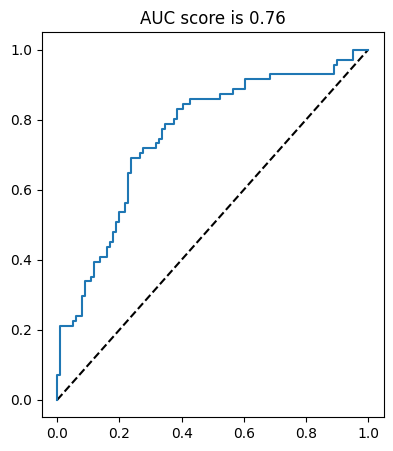

In [57]:
classifier=svm.SVC(C=1,kernel='rbf',decision_function_shape='ovo',probability=True) # ovo:一对一策略
support=classifier.fit(X_train,y_train) 

# Plot our model results 
fpr, tpr, _ = roc_curve(y_test, support.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, support.predict_proba(X_test)[:,1])))

predicted = support.predict(X_test)
print(classification_report(y_test, predicted))

Stakes distribution in the wrong predictions
False    0.830189
True     0.169811
Name: is_stake, dtype: float64
Stakes distribution overall
False    0.647674
True     0.352326
Name: is_stake, dtype: float64


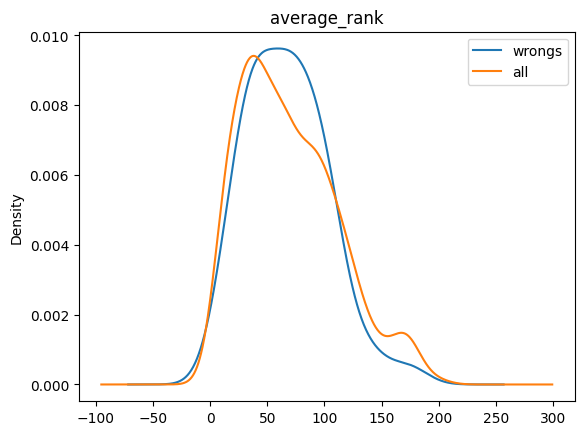

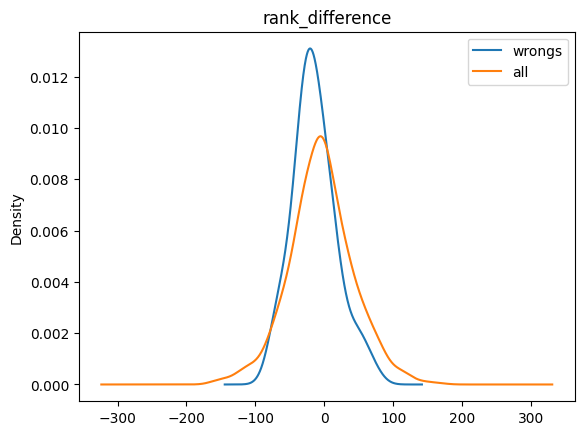

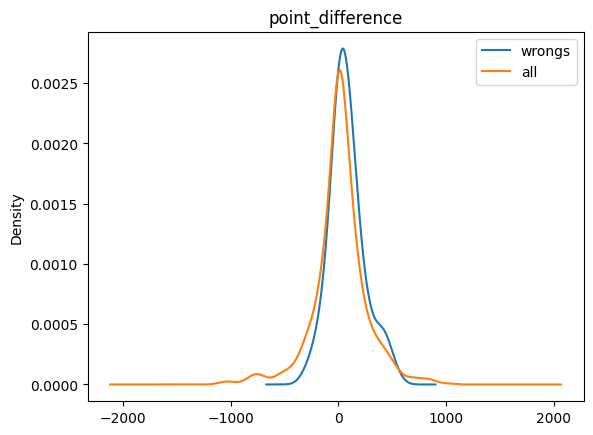

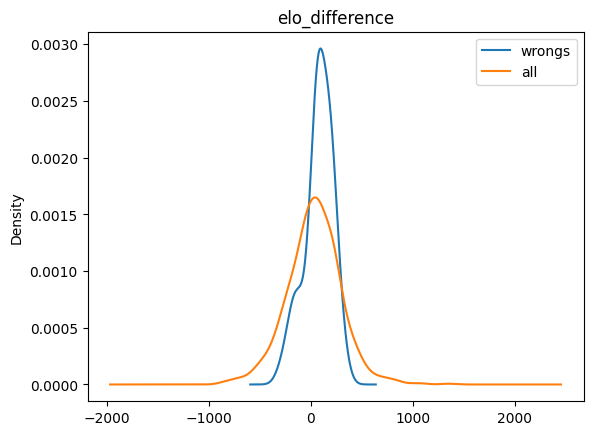

In [58]:
features = ['average_rank', 'rank_difference', 'point_difference','elo_difference']

# Get the wrongly predicted matches
wrongs = y_test != support.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

From these figures, we read

- predict worse for closer ranks
- predict worse for lower ranks in general
- predict worse for matches with no stakes (Friendly here) - fortunately, this implies that for the world cup our predicitons may be somewhat even better

## Naive Bayes

[[60 41]
 [14 57]]
              precision    recall  f1-score   support

       False       0.81      0.59      0.69       101
        True       0.58      0.80      0.67        71

    accuracy                           0.68       172
   macro avg       0.70      0.70      0.68       172
weighted avg       0.72      0.68      0.68       172

NAIVEBAYES Accuracy :  0.6802325581395349
NAIVEBAYES Auc:  0.6984381536745224


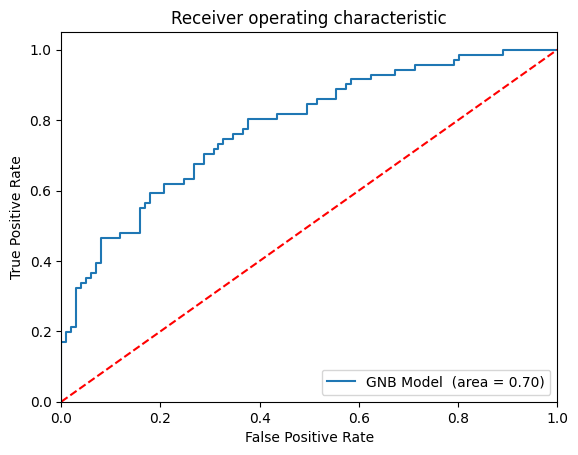

In [68]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score

### Gussian Naive Bayes Algorithm
gnb = GaussianNB()
 
 
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
 
print(confusion_matrix(y_test, y_pred_gnb))
 
print(classification_report(y_test, y_pred_gnb))
 
 
### Model Accuracies
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print ("NAIVEBAYES Accuracy : " ,accuracy_gnb)
 
 
gnb_roc_auc = roc_auc_score(y_test, gnb.predict(X_test))
print ("NAIVEBAYES Auc: ", gnb_roc_auc)
 
 
fpr1_gnb, tpr1_gnb, thresholds1_gnb = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
 
### Plot the ROC curves
plt.figure()
plt.plot(fpr1_gnb, tpr1_gnb, label='GNB Model  (area = %0.2f)' % gnb_roc_auc)
 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Stakes distribution in the wrong predictions
False    0.830189
True     0.169811
Name: is_stake, dtype: float64
Stakes distribution overall
False    0.647674
True     0.352326
Name: is_stake, dtype: float64


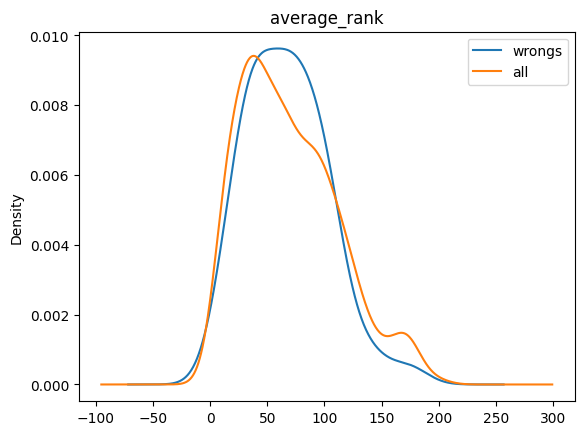

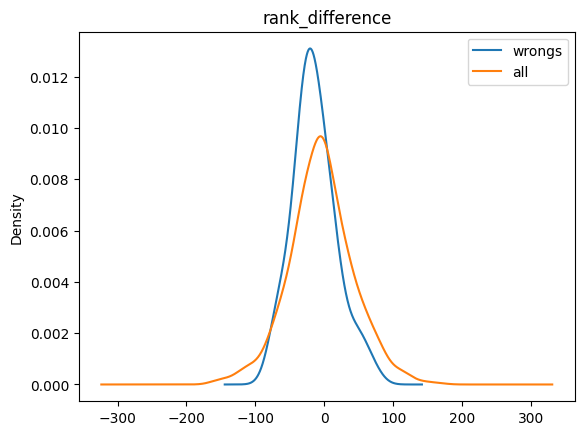

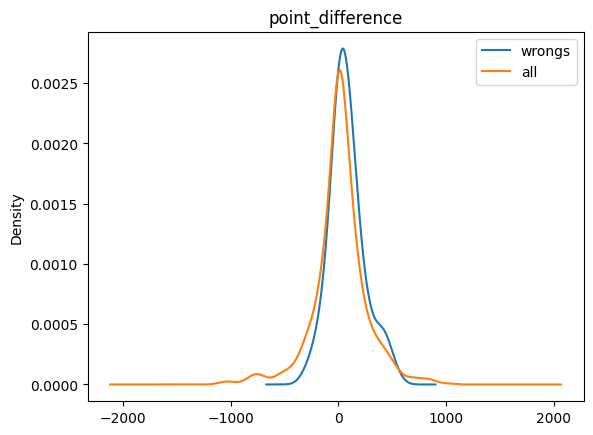

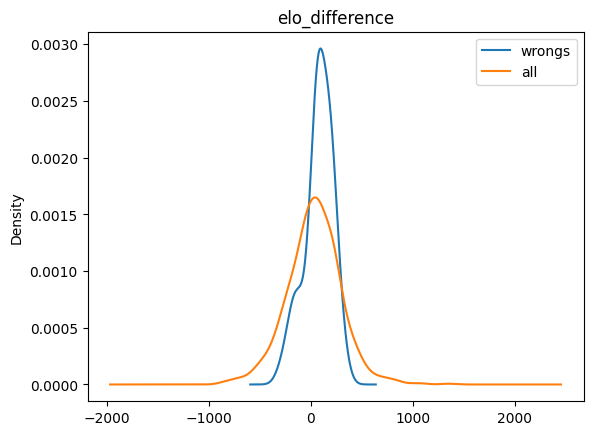

In [69]:
features = ['average_rank', 'rank_difference', 'point_difference','elo_difference']

# Get the wrongly predicted matches
wrongs = y_test != support.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

From these figures, we read

- predict worse for closer ranks
- predict worse for lower ranks in general
- predict worse for matches with no stakes (Friendly here) - fortunately, this implies that for the world cup our predicitons may be somewhat even better

## Prediction for world cup 2022 using SVM

In [59]:
world_cup_rankings

,rank_date,rank,country_abrv,total_points,previous_points,rank_change,confederation,year,country,elo
country_full,,,,,,,,,,
Denmark,2022-10-06,10,DEN,1666.57,1665.47,0,UEFA,2022,Denmark,1937
Canada,2022-10-06,41,CAN,1475.00,1473.82,-2,CONCACAF,2022,Canada,1785
Tunisia,2022-10-06,30,TUN,1507.54,1507.86,0,CAF,2022,Tunisia,1640
Australia,2022-10-06,38,AUS,1488.72,1483.73,-1,AFC,2022,Australia,1733
Cameroon,2022-10-06,43,CMR,1471.44,1484.95,5,CAF,2022,Cameroon,1610
Korea Republic,2022-10-06,28,KOR,1530.30,1526.02,0,AFC,2022,Korea Republic,1787
Costa Rica,2022-10-06,31,CRC,1503.59,1500.06,-3,CONCACAF,2022,Costa Rica,1618
Ecuador,2022-10-06,44,ECU,1464.39,1463.74,0,CONMEBOL,2022,Ecuador,1849
Poland,2022-10-06,26,POL,1548.59,1546.18,0,UEFA,2022,Poland,1770


In [60]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

# We iterate through each game in the schedule, doing each group at a time
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))

    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)

        # Get features for each team competiting in the fixture
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        home_elo = world_cup_rankings.loc[home, 'elo']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        opp_elo = world_cup_rankings.loc[away, 'elo']
        
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo
        
        # get the prediction proability of the home team winning
        home_win_prob = support.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        # Allocate points 
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group F:___
Croatia vs. Canada: Croatia wins with 0.59
Croatia vs. Belgium: Belgium wins with 0.72
Croatia vs. Morocco: Croatia wins with 0.61
Canada vs. Belgium: Belgium wins with 0.72
Canada vs. Morocco: Morocco wins with 0.56
Belgium vs. Morocco: Belgium wins with 0.72
___Starting group G:___
Serbia vs. Cameroon: Serbia wins with 0.74
Serbia vs. Switzerland: Switzerland wins with 0.68
Serbia vs. Brazil: Brazil wins with 0.71
Cameroon vs. Switzerland: Switzerland wins with 0.71
Cameroon vs. Brazil: Brazil wins with 0.73
Switzerland vs. Brazil: Brazil wins with 0.72
___Starting group B:___
England vs. Iran: England wins with 0.71
England vs. Wales: England wins with 0.71
England vs. USA: England wins with 0.69
Iran vs. Wales: Wales wins with 0.56
Iran vs. USA: USA wins with 0.61
Wales vs. USA: USA wins with 0.61
___Starting group E:___
Japan vs. Costa Rica: Japan wins with 0.67
Japan vs. Spain: Spain wins with 0.71
Japan vs. Germany: Germany wins with 0.72
Costa Rica vs. S

In [61]:
world_cup

,Group,First match against,Second match against,Third match against,points,total_prob
Team,,,,,,
Qatar,A,Ecuador,Senegal,Netherland,0,0.900650
Ecuador,A,Qatar,Netherland,Senegal,6,1.619461
Senegal,A,Netherland,Qatar,Ecuador,3,1.341051
Netherland,A,Senegal,Ecuador,Qatar,9,2.138838
England,B,Iran,USA,Wales,9,2.107709
Iran,B,England,Wales,USA,0,1.119359
Wales,B,USA,Iran,England,3,1.248908
USA,B,Wales,England,Iran,6,1.524023
Poland,C,Mexico,Saudi Arabia,Argentina,3,1.302438


In [62]:
# Hardcode the mappings
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

next_round_wc.sort_values(by='Group')

,Group,First match against,Second match against,Third match against,points,total_prob
Team,,,,,,
Netherland,A,Senegal,Ecuador,Qatar,9,2.138838
Ecuador,A,Qatar,Netherland,Senegal,6,1.619461
USA,B,Wales,England,Iran,6,1.524023
England,B,Iran,USA,Wales,9,2.107709
Argentina,C,Saudi Arabia,Mexico,Poland,9,2.166708
Mexico,C,Poland,Argentina,Saudi Arabia,6,1.659745
Denmark,D,Tunisia,France,Australia,6,1.758810
France,D,Australia,Denmark,Tunisia,9,2.126186
Spain,E,Costa Rica,Germany,Japan,9,1.996499


In [63]:
finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

# for each knockout stage
for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        # get the teams playing
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        
        # get the features for each team
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan,np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        home_elo = world_cup_rankings.loc[home, 'elo']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        opp_elo = world_cup_rankings.loc[away, 'elo']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo

        # Get the winner
        home_win_prob = support.predict_proba(row)[:,1][0]
        
        # Display resultes
        if support.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        # Display winning team and probability of victory
        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Netherland vs. USA: Netherland wins with probability 0.56
Argentina vs. Denmark: Argentina wins with probability 0.68
Spain vs. Croatia: Spain wins with probability 0.70
Brazil vs. Uruguay: Brazil wins with probability 0.72
Ecuador vs. England: England wins with probability 0.72
Mexico vs. France: France wins with probability 0.71
Germany vs. Belgium: Belgium wins with probability 0.70
Switzerland vs. Portugal: Portugal wins with probability 0.63


___Starting of the quarterfinal___
Netherland vs. Argentina: Argentina wins with probability 0.72
Spain vs. Brazil: Brazil wins with probability 0.70
England vs. France: France wins with probability 0.67
Belgium vs. Portugal: Belgium wins with probability 0.62


___Starting of the semifinal___
Argentina vs. Brazil: Brazil wins with probability 0.64
France vs. Belgium: Belgium wins with probability 0.52


___Starting of the final___
Brazil vs. Belgium: Brazil wins with probability 0.56




## Prediction of world cup 2022 using Naive Bayes Classifer (Gaussian Classifier)

In [ ]:
world_cup_rankings

In [73]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

# We iterate through each game in the schedule, doing each group at a time
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))

    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)

        # Get features for each team competiting in the fixture
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        home_elo = world_cup_rankings.loc[home, 'elo']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        opp_elo = world_cup_rankings.loc[away, 'elo']
        
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo
        
        # get the prediction proability of the home team winning
        home_win_prob = gnb.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        # Allocate points 
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group F:___
Croatia vs. Canada: Croatia wins with 0.79
Croatia vs. Belgium: Belgium wins with 0.83
Croatia vs. Morocco: Croatia wins with 0.70
Canada vs. Belgium: Belgium wins with 0.96
Canada vs. Morocco: Morocco wins with 0.61
Belgium vs. Morocco: Belgium wins with 0.90
___Starting group G:___
Serbia vs. Cameroon: Serbia wins with 0.85
Serbia vs. Switzerland: Switzerland wins with 0.65
Serbia vs. Brazil: Brazil wins with 0.93
Cameroon vs. Switzerland: Switzerland wins with 0.91
Cameroon vs. Brazil: Brazil wins with 0.99
Switzerland vs. Brazil: Brazil wins with 0.86
___Starting group B:___
England vs. Iran: England wins with 0.82
England vs. Wales: England wins with 0.82
England vs. USA: England wins with 0.77
Iran vs. Wales: Draw
Iran vs. USA: USA wins with 0.57
Wales vs. USA: USA wins with 0.56
___Starting group E:___
Japan vs. Costa Rica: Japan wins with 0.73
Japan vs. Spain: Spain wins with 0.87
Japan vs. Germany: Germany wins with 0.78
Costa Rica vs. Spain: Spain wins

In [74]:
world_cup

,Group,First match against,Second match against,Third match against,points,total_prob
Team,,,,,,
Qatar,A,Ecuador,Senegal,Netherland,0,0.606610
Ecuador,A,Qatar,Netherland,Senegal,3,1.273159
Senegal,A,Netherland,Qatar,Ecuador,6,1.520907
Netherland,A,Senegal,Ecuador,Qatar,9,2.599324
England,B,Iran,USA,Wales,9,2.406791
Iran,B,England,Wales,USA,1,1.123474
Wales,B,USA,Iran,England,1,1.110327
USA,B,Wales,England,Iran,6,1.359408
Poland,C,Mexico,Saudi Arabia,Argentina,3,1.204582


In [75]:
# Hardcode the mappings
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

next_round_wc.sort_values(by='Group')

,Group,First match against,Second match against,Third match against,points,total_prob
Team,,,,,,
Netherland,A,Senegal,Ecuador,Qatar,9,2.599324
Senegal,A,Netherland,Qatar,Ecuador,6,1.520907
USA,B,Wales,England,Iran,6,1.359408
England,B,Iran,USA,Wales,9,2.406791
Argentina,C,Saudi Arabia,Mexico,Poland,9,2.743957
Mexico,C,Poland,Argentina,Saudi Arabia,6,1.753457
Denmark,D,Tunisia,France,Australia,6,2.002488
France,D,Australia,Denmark,Tunisia,9,2.646362
Spain,E,Costa Rica,Germany,Japan,9,2.460622


In [76]:
finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

# for each knockout stage
for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        # get the teams playing
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        
        # get the features for each team
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan,np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        home_elo = world_cup_rankings.loc[home, 'elo']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        opp_elo = world_cup_rankings.loc[away, 'elo']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo

        # Get the winner
        home_win_prob = gnb.predict_proba(row)[:,1][0]
        
        # Display resultes
        if gnb.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        # Display winning team and probability of victory
        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Netherland vs. USA: Netherland wins with probability 0.66
Argentina vs. Denmark: Argentina wins with probability 0.75
Spain vs. Croatia: Spain wins with probability 0.74
Brazil vs. Uruguay: Brazil wins with probability 0.88
Senegal vs. England: England wins with probability 0.88
Mexico vs. France: France wins with probability 0.83
Germany vs. Belgium: Belgium wins with probability 0.76
Switzerland vs. Portugal: Portugal wins with probability 0.58


___Starting of the quarterfinal___
Netherland vs. Argentina: Argentina wins with probability 0.73
Spain vs. Brazil: Brazil wins with probability 0.72
England vs. France: France wins with probability 0.60
Belgium vs. Portugal: Belgium wins with probability 0.72


___Starting of the semifinal___
Argentina vs. Brazil: Brazil wins with probability 0.60
France vs. Belgium: Belgium wins with probability 0.50


___Starting of the final___
Brazil vs. Belgium: Brazil wins with probability 0.60




## Comments

As svm and naive bayes give different answers which are Belgium and Brazil respectively, while the auc is different with auc of svm is 0.76 and that of naive bayes is 0.70, we choose svm as a better model.

## Visualization

In [ ]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)

# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()

C:\Users\陈素青\AppData\Local\Temp\ipykernel_19712\2909479906.py:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='twopi')


FileNotFoundError: [WinError 2] "twopi" not found in path.

# Other Implementation of new variables

With Simon's inspiration, we consider using appearance as a new feature for the game. Similar process, but a little bit useful.

I will just import the preprocessed data for using. and only using *SVM* as an example.

In [ ]:
#import the processed data

matches = pd.read_csv("https://raw.githubusercontent.com/iamtlcs/STAT3011-Group5-Project2/main/archive/matches_merged.csv")

matches['point_difference'] = matches['total_points_home'] - matches['total_points_away']
matches['elo_difference'] = matches['elo_home'] - matches['elo_away']
matches['appearance_difference'] = matches['home_appearance'] - matches['away_appearance']

matches.T

In [ ]:
# We look at only 4 features
X, y = matches.loc[:,['appearance_difference','average_rank', 'rank_difference', 'point_difference','elo_difference', 'is_stake']], matches['is_won']

# Create our test and train datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
X.head()

In [ ]:
classifier=svm.SVC(C=1,kernel='rbf',decision_function_shape='ovo',probability=True) # ovo:一对一策略
support=classifier.fit(X_train,y_train) 

# Plot our model results 
fpr, tpr, _ = roc_curve(y_test, support.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, support.predict_proba(X_test)[:,1])))

predicted = support.predict(X_test)
print(classification_report(y_test, predicted))

In [ ]:
features = ['appearance_difference','average_rank', 'rank_difference', 'point_difference','elo_difference']

# Get the wrongly predicted matches
wrongs = y_test != support.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

In [ ]:
world_cup_rankings = pd.read_csv("https://raw.githubusercontent.com/iamtlcs/STAT3011-Group5-Project2/main/archive/appearance_world_2022.csv")

world_cup_rankings = world_cup_rankings.set_index(['country_full'])

world_cup_rankings

In [ ]:
from itertools import combinations
margin = 0.025
opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

# We iterate through each game in the schedule, doing each group at a time
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))

    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan,np.nan, np.nan, True]]), columns=X_test.columns)

        # Get features for each team competiting in the fixture
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        home_elo = world_cup_rankings.loc[home, 'elo']
        home_appearance = world_cup_rankings.loc[home, 'appearance']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        opp_elo = world_cup_rankings.loc[away, 'elo']
        opp_appearance = world_cup_rankings.loc[away, 'appearance']
        
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo
        row['appearance_difference'] = home_appearance - opp_appearance
        
        # get the prediction proability of the home team winning
        home_win_prob = support.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        # Allocate points 
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

In [ ]:
# Hardcode the mappings
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

next_round_wc.sort_values(by='Group')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

# for each knockout stage
for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        # get the teams playing
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        
        # get the features for each team
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan,np.nan,np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        home_elo = world_cup_rankings.loc[home, 'elo']
        home_appearance = world_cup_rankings.loc[home, 'appearance']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        opp_elo = world_cup_rankings.loc[away, 'elo']
        opp_appearance = world_cup_rankings.loc[away, 'appearance']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo
        row['appearance_difference'] = home_appearance - opp_appearance

        # Get the winner
        home_win_prob = support.predict_proba(row)[:,1][0]
        
        # Display resultes
        if support.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        # Display winning team and probability of victory
        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

Same results with Brazil as the final winner.